In [115]:
xls.prep <- function(formula,data,dependent_var){
    
    matrix.baked <- stats::model.matrix(formula,data)
    
    df.baked <- base::as.data.frame(matrix.baked)
    
    base::rm(matrix.baked)
    
    varnum <- base::ncol(df.baked)
    
    varnames <- base::colnames(df.baked)
    
    coefnames <- base::paste0('x[',1:varnum,']')
    
    regformat <- base::paste(base::rep('%s*%s',varnum),collapse = ' + ')
    
    coef_var_match <- NULL
    
    for(i in 1:varnum){
        coef_var_match[i] <- base::sprintf('"%s",df.baked[["%s"]]',coefnames[i],varnames[i])
    }
    
    coef_var_match <- base::paste(coef_var_match,collapse = ',')
    
    symbolic_error_calculation <- base::sprintf('base::sprintf("%s",%s)',regformat,coef_var_match)
    
    base::eval(base::parse(text = base::sprintf('df.baked[["error_symbolic"]] <- %s',symbolic_error_calculation)))
    
    df.baked[["error_symbolic"]] <- base::sprintf('(%s - %s)^2',df.baked[["error_symbolic"]],data[[dependent_var]])

    base::list(data=df.baked,independent_var=varnames)

}

In [116]:
xls.objfun <- function(data,error_column_name,args,error_weights,error_ahead_level){
    
    df <- data
    
    sample_size <- nrow(df)
    
    df$ahead_error_symbolic <- base::sapply(
      1:sample_size,
      function(x) paste(df[[error_column_name]][x:min(x+error_ahead_level-1, sample_size)], collapse = " add ")
    )
    
    df$ahead_num <- sapply(strsplit(df$ahead_error_symbolic,split = ' add '),length)
    
    df <- subset(df,ahead_num == error_ahead_level)
    
    df$ahead_error_symbolic <- strsplit(df$ahead_error_symbolic,' add ')
    
    new_sample_size <- nrow(df)
    
    df$error_weights <- rep(list(error_weights),new_sample_size)
    
    new_error_column <- paste0(error_column_name,'_weighted')
    
    df[[new_error_column]] <- mapply(
      paste,
      df$error_weights,
      df$ahead_error_symbolic,
      sep = "*",
      collapse = " + "
    )

    sum_of_errors <- base::paste(df[[new_error_column]],collapse = ' + ')
    
    multivariate_sse <- base::gsub("x\\[(\\d)\\]", "x\\1", sum_of_errors)
    
    base::suppressMessages({polynomial_sse <-  mpoly::mp(multivariate_sse, stars = TRUE)})
    
    base::suppressMessages({objfun <-  base::as.function(polynomial_sse, varorder = base::sort(mpoly::vars(polynomial_sse)))})
    
    base::list(objective = objfun,sum_of_errors = sum_of_errors)
}

In [117]:
xls.fit <- function(formula,
                    data,
                    lag_level=1,
                    error_weights = NULL,
                    error_ahead_level=4){
    
    if(base::nrow(data) < error_ahead_level){
        
        base::stop('The number of observations must be greater than error ahead level.')
        
    }
    
    dependent_var <- base::all.vars(formula)[1]
    
    if(base::is.null(error_weights)){
        
        dummy_weights <- base::seq(from = 0,to = 1,length.out = error_ahead_level + 1)
        error_weights <- dummy_weights[-1]/base::sum(dummy_weights[-1])
        error_weights <- rev(error_weights)
        base::rm(dummy_weights)
        
    }else if(base::length(error_weights) != error_ahead_level){
        
        base::stop('Error weights should have same length with ahead level.')
        
    }else if(base::sum(error_weights) != 1){
        
        base::stop('The sum of the error weights must be 1.')
        
    }
    
    prepared_obj <- xls.prep(formula,data,dependent_var)
    
    df <- prepared_obj$data
    
    independent_var <- prepared_obj$independent_var
    
    initial_solution <- base::rep(0,base::length(independent_var))

    objfun_object <- xls.objfun(data = df,error_column_name = 'error_symbolic',
                                args = 'x',error_weights = error_weights, error_ahead_level = error_ahead_level)
    
    objfun <- objfun_object$objective

    optimizing_parameters <- stats::optim(par = initial_solution,fn = objfun)
    
    coefficients <- base::as.data.frame(optimizing_parameters$par)
    
    base::colnames(coefficients) <- 'coef'
    
    base::rownames(coefficients) <- independent_var

    dummy_model <- stats::lm(formula,data)
    
    coefficients_vec <- coefficients$coef
    
    names(coefficients_vec) <- base::rownames(coefficients)
    
    dummy_model <- stats::lm(formula = formula,data = data)
    
    dummy_model$coefficients <- coefficients_vec
    
    dataname <- rlang::sym(base::deparse(base::substitute(data)))
    
    dummy_model$call <- base::call('xls.fit',formula = formula,data = dataname,error_weights = error_weights,error_ahead_level = error_ahead_level)
    
    dummy_model

}

In [118]:
xls.fit(Sepal.Width ~ Petal.Length,iris,error_weights = c(0.4,0.3,0.2,0.1),error_ahead_level = 4)


Call:
xls.fit(formula = Sepal.Width ~ Petal.Length, data = iris, error_weights = c(0.4, 
0.3, 0.2, 0.1), error_ahead_level = 4)

Coefficients:
 (Intercept)  Petal.Length  
      3.4569       -0.1073  


In [96]:
base::lm

[1] "iris"

In [27]:
a <- lm(Sepal.Width ~ Petal.Length,iris)

In [37]:
ar <- capture.output(dput(a))

In [39]:
are <- eval(parse(text=paste(ar,collapse = '')))

In [52]:
a$call <- call("xls.fit", Sepal.Length ~ Petal.Length, 
                   data=quote(iris), foo=NULL)

In [55]:
call()


Call:
xls.fit(Sepal.Length ~ Petal.Length, data = iris, foo = NULL)

Coefficients:
 (Intercept)  Petal.Length  
      3.4549       -0.1058  


    ---------

In [6]:
library(data.table)

In [10]:
DF <- data.table(Var2 = c(1,1,0,0,1),Var3 = c(24,18,5,16,12),Y = c(4,15,8,13,18))

In [11]:
DF[, Var1 := shift(Y,n = 1)]

DF <- DF[,.SD,.SDcols = c('Var1','Var2','Var3','Y')]

DF <- na.omit(DF)

In [12]:
DF

Var1,Var2,Var3,Y
<dbl>,<dbl>,<dbl>,<dbl>
4,1,18,15
15,0,5,8
8,0,16,13
13,1,12,18


In [20]:
inital_model <- lm(Y ~ Var1 + Var2 + Var3 - 1,DF)

In [21]:
DF[, PRED := predict(inital_model,DF)]

In [24]:
predict(inital_model,DF)

1         2         3         4 
16.212534  9.164033 12.181540 16.787466

In [28]:
DF

Var1,Var2,Var3,Y,PRED
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
4,1,18,15,16.212534
15,0,5,8,9.164033
8,0,16,13,12.181540
13,1,12,18,16.787466


In [33]:
symbolic_error_sum <- '0.6*(x[1]*4 + x[2] + x[3]*18 - 15)**2 + 0.4*(x[1]*16.21 + x[3]*5 - 8)**2 + 
0.6*(x[1]*15 + x[3]*5 - 8)**2 + 0.4*(x[1]*9.16 + x[3]*16 - 13)**2 + 0.6*(x[1]*8 + x[3]*16 - 13)**2 + 0.4*(x[1]*12.18 + x[2] + x[3]*12 - 18)**2'

In [35]:
eval(parse(text = sprintf('ses_objfun <- function(x) {%s}',symbolic_error_sum)))

In [37]:
txt <- deparse1(body(ses_objfun))
txt2 <- gsub("x\\[(\\d)\\]", "x\\1", txt)

In [40]:
library(mpoly)

p <- mp(txt2, stars = TRUE)
fs <- as.function(p, varorder = sort(vars(p)))

f(.) with . = (x1, x2, x3)



In [50]:
newcoef <- optim(c(0,0,0),fs)$par 

names(newcoef) <- paste0('Var',1:3)

In [51]:
reshaped_model <- inital_model

In [52]:
reshaped_model$coefficients <- newcoef

In [53]:
reshaped_model


Call:
lm(formula = Y ~ Var1 + Var2 + Var3 - 1, data = DF)

Coefficients:
  Var1    Var2    Var3  
0.3746  4.4082  0.5812  


In [58]:
DF[,PRED2 := predict(reshaped_model,DF)]

In [ ]:
DF[,ERROR1 := PRED - Y]

DF[,ERROR2 := PRED2 - Y]

DF[,ERROR3 := PRED2 - PRED]

In [65]:
library(ggplot2)
library(dplyr)


Attaching package: ‘ggplot2’


The following object is masked from ‘package:mpoly’:

    vars



Attaching package: ‘dplyr’


The following object is masked from ‘package:mpoly’:

    vars


The following objects are masked from ‘package:data.table’:

    between, first, last


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




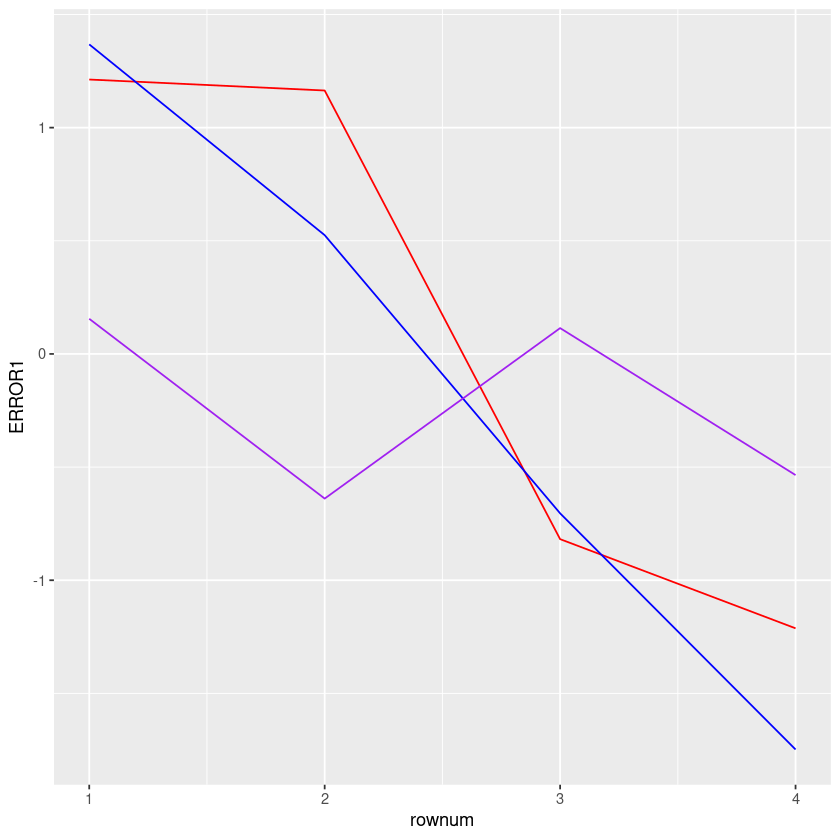

In [67]:
DF %>% 
mutate(rownum = 1:n()) %>% 
ggplot()+
geom_line(aes(x=rownum , y = ERROR1),color='red')+
geom_line(aes(x=rownum , y = ERROR2),color='blue')+
geom_line(aes(x=rownum , y = ERROR3),color='purple')

In [68]:
inital_model


Call:
lm(formula = Y ~ Var1 + Var2 + Var3 - 1, data = DF)

Coefficients:
  Var1    Var2    Var3  
0.4286  4.6512  0.5471  


In [69]:
reshaped_model


Call:
lm(formula = Y ~ Var1 + Var2 + Var3 - 1, data = DF)

Coefficients:
  Var1    Var2    Var3  
0.3746  4.4082  0.5812  


In [75]:
DF[,.(inital_SSE = sum(ERROR1**2), reshaped_SSE = sum(ERROR2**2))][,.(ratio = reshaped_SSE / inital_SSE)]

ratio
<dbl>
1.147479
